# **Data Exploration: Inspect raw datasets**
Run after setup (python ../setup.py).

## Dataset Selection Rationale for Micro-Scale Lahore Congestion Prediction

The objective of this project is to predict short-term traffic congestion in Lahore at a micro temporal scale (15-minute windows). Achieving this requires data that collectively captures **traffic demand**, **human activity patterns**, **environmental conditions**, and **road network structure**. No single dataset can fully represent all these dimensions; therefore, multiple complementary data sources are selected to approximate congestion dynamics from different angles.

This section explains *why* each dataset is included, without assuming prior familiarity with their contents.

---

### Road Traffic Accident (RTA) Records
Traffic accidents are strong real-world indicators of congestion. Even minor incidents can significantly disrupt traffic flow, particularly in dense urban areas like Lahore. The RTA dataset provides time-stamped emergency call records associated with road traffic incidents, including response times, causes of accidents, vehicle involvement, and injury severity.

Although this dataset does not directly measure congestion, it captures **disruptive events** that are known to create short-term traffic bottlenecks. Its high temporal resolution makes it especially relevant for 15-minute prediction windows, as accident-related delays often manifest almost immediately. In the absence of continuous traffic sensor data, accident frequency and timing serve as an important proxy for sudden congestion spikes.

---

### Population Mobility Trends
Traffic congestion is fundamentally driven by how many people are moving and where they are going. Google’s mobility data offers insight into **aggregate movement behavior**, such as changes in workplace attendance, transit usage, and residential stay patterns over time.

While mobility data is spatially coarse, it provides crucial **demand-side context**. Increases in workplace or transit mobility often correspond to higher vehicle density on roads, especially during peak hours. For a short-horizon prediction task, mobility trends help capture background traffic intensity and societal behavior (e.g., workdays vs. weekends, lockdown effects), which directly influence congestion probability even at micro time scales.

---

### Weather Conditions
Weather directly affects driving behavior, road capacity, and travel time reliability. Rain, extreme heat, fog, or strong winds can slow traffic, increase accident likelihood, and amplify congestion even when traffic volume remains constant.

The weather dataset provides historically consistent, daily meteorological observations for Lahore and surrounding regions. These variables act as **exogenous risk factors** that help explain variations in congestion that cannot be attributed to traffic demand alone. Including weather data allows the model to distinguish between congestion caused by high traffic volume and congestion caused by reduced road efficiency.

---

### Road Network Infrastructure (OpenStreetMap)
Congestion does not occur uniformly across a city; it is constrained by road geometry, hierarchy, and connectivity. OpenStreetMap (OSM) provides a detailed digital representation of Lahore’s road network, including road types, connectivity patterns, and spatial layout.

This dataset establishes the **structural limits** within which traffic operates. Even without real-time speed data, road classification and density help explain why certain areas are more prone to congestion than others. OSM data is essential for grounding temporal predictions in physical space and for enabling future extensions such as segment-level risk scoring or spatial aggregation.

---

### Complementarity of the Selected Datasets
Each dataset captures a different but essential component of congestion dynamics:

- **RTA data** reflects sudden disruptions and incident-driven delays  
- **Mobility data** approximates traffic demand and human movement intensity  
- **Weather data** represents environmental constraints on traffic flow  
- **OSM data** defines the physical road network where congestion manifests  

Individually, these datasets are incomplete; together, they provide a multi-dimensional view of urban traffic behavior. This combination is particularly well-suited for short-term congestion prediction in data-scarce environments, where direct traffic sensor or GPS speed data is unavailable.

---

### Scope and Limitations
While the selected datasets do not directly observe vehicle speeds or queue lengths, they collectively approximate the **conditions under which congestion emerges**. This project therefore focuses on *predicting congestion likelihood and intensity patterns* rather than exact travel times. The exploratory analysis that follows evaluates the quality, coverage, and integration feasibility of each dataset to determine how effectively they support this modeling goal.


### **Imports**

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely import from_wkt
import warnings
warnings.filterwarnings("ignore")

## **RTA**

In [19]:
print("=== RTA Accidents Dataset Exploration ===")
rta_path = "../data/raw/RTA Data 2020 to July 2023.xlsx"
rta = pd.read_excel(rta_path)
print(f"Shape: {rta.shape} (rows, cols)")
print(f"Columns: {rta.columns.tolist()}")
print(f"Data types:\n{rta.dtypes}")
print(f"Missing values per column:\n{rta.isnull().sum()}")
print("\nFirst 3 rows:\n", rta.head(3).to_string())
print("\nDate-like columns sample (first 5 unique dates):\n")
date_cols = [col for col in rta.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_cols[:3]:  # Top 3 potential date/time cols
    print(f"{col}: {rta[col].dropna().unique()[:5]}")
print("\nLat/Lon sample (first 5):\n", rta[[col for col in rta.columns if 'lat' in col.lower() or 'lon' in col.lower()]].head())

=== RTA Accidents Dataset Exploration ===
Shape: (46189, 25) (rows, cols)
Columns: ['EcYear', 'EcNumber', 'CallTime', 'EmergencyArea', 'TotalPatientsInEmergency', 'Gender', 'Age', 'HospitalName', 'Reason', 'responsetime', 'EducationTitle', 'InjuryType', 'Cause', 'PatientStatus', 'BicycleInvovled', 'BikesInvolved', 'BusesInvolved', 'CarsInvolved', 'CartInvovled', 'RickshawsInvolved', 'TractorInvovled', 'TrainsInvovled', 'TrucksInvolved', 'VansInvolved', 'OthersInvolved']
Data types:
EcYear                              object
EcNumber                            object
CallTime                    datetime64[ns]
EmergencyArea                       object
TotalPatientsInEmergency            object
Gender                              object
Age                                float64
HospitalName                        object
Reason                              object
responsetime                       float64
EducationTitle                      object
InjuryType                          obje

## **Mobility**

In [20]:
print("=== PK Mobility Dataset Files Exploration===")
files = [
    "../data/raw/2020_PK_Region_Mobility_Report.xlsx",
    "../data/raw/2021_PK_Region_Mobility_Report.xlsx",
    "../data/raw/2022_PK_Region_Mobility_Report.xlsx"
]

dfs = []
for file in files:
    df = pd.read_excel(file)
    df['datetime'] = pd.to_datetime(df['date'])
    dfs.append(df)
mob_pk = pd.concat(dfs, ignore_index=True)
print(f"Concat shape: {mob_pk.shape}")
print("Columns:", mob_pk.columns.tolist())
print("Unique sub_region_1:", mob_pk['sub_region_1'].unique())
print("Unique sub_region_2:", mob_pk['sub_region_2'].unique()[:10])  # Top 10
print("\nSample:\n", mob_pk.head(3)[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline']].to_string())

=== PK Mobility Dataset Files Exploration===
Concat shape: (20404, 16)
Columns: ['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'datetime']
Unique sub_region_1: [nan 'Azad Jammu and Kashmir' 'Balochistan'
 'Federally Administered Tribal Area' 'Gilgit-Baltistan'
 'Islamabad Capital Territory' 'Khyber Pakhtunkhwa' 'Punjab' 'Sindh']
Unique sub_region_2: [nan]

Sample:
   sub_region_1  sub_region_2       date  workplaces_percent_change_from_baseline
0          NaN           NaN 2020-02-15                                      2.0
1          NaN           NaN 2020-02-16                                      2.0
2       

## **Weather**

In [22]:
print("=== Weather Datasets Exploration ===")
w1_path = "../data/raw/pakistan_weather_2000_2024.csv"
w2_path = "../data/raw/pakistan_weather_data-Sep2024-Oct2025.csv"
w1 = pd.read_csv(w1_path)
w2 = pd.read_csv(w2_path)
weather = pd.concat([w1, w2], ignore_index=True)
print(f"Combined shape: {weather.shape}")
print(f"Columns: {weather.columns.tolist()}")
print(f"Data types:\n{weather.dtypes}")
print(f"Missing values per column:\n{weather.isnull().sum()}")
print("\nFirst 3 rows:\n", weather.head(3).to_string())
print("\nLahore sample (first 5 rows):\n")
lahore_sample = weather[weather['city'].str.contains('Lahore', na=False, case=False)].head()
print(lahore_sample.to_string())
print(f"\nUnique cities: {weather['city'].unique()[:10]}")
print(f"Date range: {weather['date'].min()} to {weather['date'].max()}")

=== Weather Datasets Exploration ===
Combined shape: (34245, 27)
Columns: ['date', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'season', 'city', 'region', 'latitude', 'longitude', 'elevation', 'tmin', 'tmax', 'tavg', 'prcp', 'wspd', 'humidity', 'pressure', 'dew_point', 'cloud_cover', 'visibility', 'temp_range', 'is_hot_day', 'is_cold_day', 'rainfall_intensity', 'wind_category']
Data types:
date                   object
year                    int64
month                   int64
day                     int64
dayofweek               int64
is_weekend              int64
season                 object
city                   object
region                 object
latitude              float64
longitude             float64
elevation             float64
tmin                  float64
tmax                  float64
tavg                  float64
prcp                  float64
wspd                  float64
humidity              float64
pressure              float64
dew_point             float64


## **OSM**

=== Loading Shapefile (.shp + .dbf) + Exploration ===
✓ Loaded successfully!
Shape: (1077644, 15) (rows, cols)
Columns (from .dbf): ['name', 'name_en', 'highway', 'surface', 'smoothness', 'width', 'lanes', 'oneway', 'bridge', 'layer', 'source', 'name_ur', 'osm_id', 'osm_type', 'geometry']
CRS: None
✓ CRS set to EPSG:4326 (WGS84).

Data types:
name            object
name_en         object
highway         object
surface         object
smoothness      object
width           object
lanes           object
oneway          object
bridge          object
layer           object
source          object
name_ur         object
osm_id           int64
osm_type        object
geometry      geometry

Missing values per column:
name          1027806
name_en       1062345
highway             0
surface        968495
smoothness    1071409
width         1074760
lanes         1034227
oneway        1040835
bridge        1049363
layer         1048433
source         959239
name_ur       1062470
osm_id            

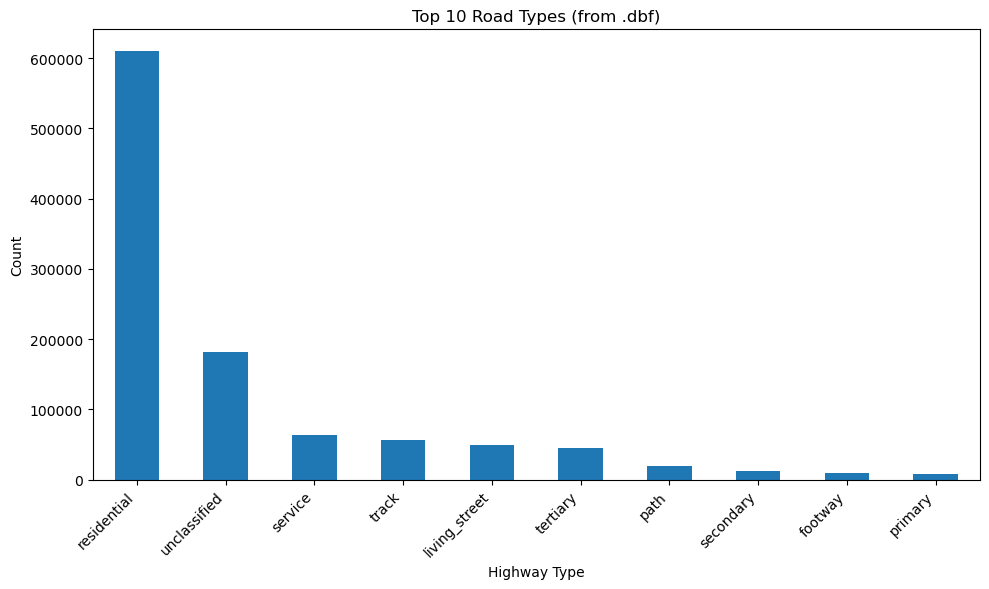


=== Lahore Subset Exploration (Bbox Filter) ===
Lahore subset shape: (79354, 15)
Lahore length stats (degrees):
 count    79354.0000
mean         0.0017
std          0.0030
min          0.0000
25%          0.0005
50%          0.0010
75%          0.0019
max          0.2015
Name: length_deg, dtype: float64


<Figure size 1000x800 with 0 Axes>

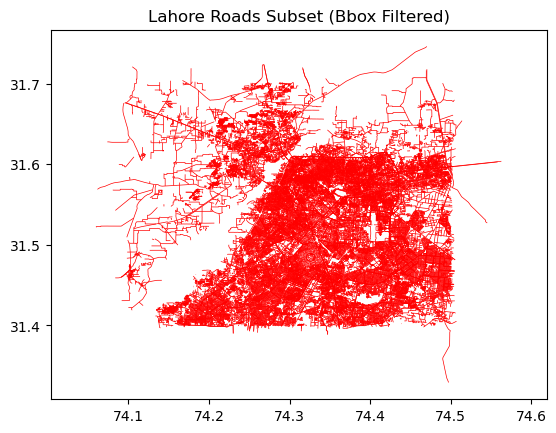


=== Full Dataset Plot (Dense—Zoom Out) ===


<Figure size 1200x800 with 0 Axes>

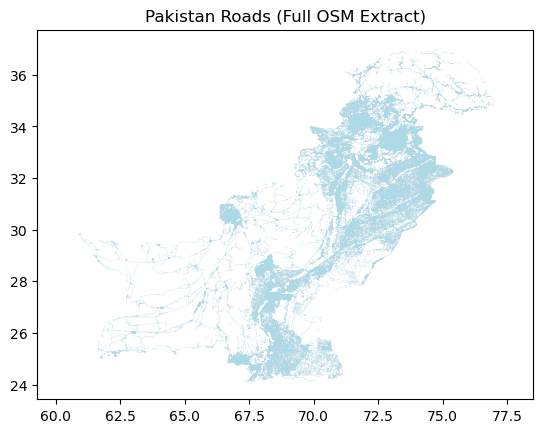

In [28]:
# Path to shapefile (keep .shp + .dbf + .shx together)
shapefile_path = "../data/raw/hotosm_pak_roads_lines_shp.shp"

print("=== Loading Shapefile (.shp + .dbf) + Exploration ===")
# Load (auto-handles .dbf attributes)
roads_gdf = gpd.read_file(shapefile_path)

print("✓ Loaded successfully!")
print(f"Shape: {roads_gdf.shape} (rows, cols)")
print(f"Columns (from .dbf): {roads_gdf.columns.tolist()}")
print(f"CRS: {roads_gdf.crs}")

# Set CRS if None (OSM standard)
if roads_gdf.crs is None:
    roads_gdf = roads_gdf.set_crs("EPSG:4326", allow_override=True)
    print("✓ CRS set to EPSG:4326 (WGS84).")

print(f"\nData types:\n{roads_gdf.dtypes.to_string()}")
print(f"\nMissing values per column:\n{roads_gdf.isnull().sum().to_string()}")

print("\n=== First 3 Rows (Attributes + Geometry Sample) ===")
print(roads_gdf.head(3).to_string(index=False))

print("\n=== Geometry Inspection ===")
print(f"Bounds: {roads_gdf.total_bounds}")  # (minx, miny, maxx, maxy)
print(f"Geometry types: {roads_gdf.geometry.geom_type.unique()}")
print(f"Valid geometries: {roads_gdf.geometry.is_valid.sum()} / {len(roads_gdf)} ({roads_gdf.geometry.is_valid.mean():.1%})")
print(f"Empty geometries: {roads_gdf.geometry.is_empty.sum()} / {len(roads_gdf)} ({roads_gdf.geometry.is_empty.mean():.1%})")

print("\n=== Attribute Analysis (Road Types from .dbf) ===")
if 'highway' in roads_gdf.columns:
    highway_counts = roads_gdf['highway'].value_counts().head(10)
    print(highway_counts.to_string())
    # Plot
    plt.figure(figsize=(10, 6))
    highway_counts.plot(kind='bar')
    plt.title("Top 10 Road Types (from .dbf)")
    plt.xlabel("Highway Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No 'highway' column in .dbf.")

print("\n=== Lahore Subset Exploration (Bbox Filter) ===")
# Lahore bbox for demo (minx, miny, maxx, maxy)
lahore_bbox = (74.1, 31.4, 74.5, 31.7)
lahore_roads = roads_gdf.cx[lahore_bbox[0]:lahore_bbox[2], lahore_bbox[1]:lahore_bbox[3]]
print(f"Lahore subset shape: {lahore_roads.shape}")

if 'length' not in lahore_roads.columns:
    # Approx length in WGS84 (degrees; for UTM project if needed)
    lahore_roads['length_deg'] = lahore_roads.geometry.length
print("Lahore length stats (degrees):\n", lahore_roads['length_deg'].describe().round(4))

# Plot Lahore subset
plt.figure(figsize=(10, 8))
lahore_roads.plot(color='red', linewidth=0.5)
plt.title("Lahore Roads Subset (Bbox Filtered)")
plt.axis('equal')
plt.show()

print("\n=== Full Dataset Plot (Dense—Zoom Out) ===")
plt.figure(figsize=(12, 8))
roads_gdf.plot(color='lightblue', linewidth=0.3, alpha=0.6)
plt.title("Pakistan Roads (Full OSM Extract)")
plt.axis('equal')
plt.show()


## Integrated Insights from Multi-Source Data Exploration

This exploratory analysis brings together four heterogeneous but complementary data sources—road traffic accident (RTA) records, population mobility trends, historical weather data, and OpenStreetMap (OSM) road infrastructure—to understand both the opportunities and limitations of modeling traffic risk in Pakistan.

### Road Traffic Accidents (RTA)
The RTA dataset is event-level and human-centric, containing over 46,000 emergency call records with detailed attributes on victims, injury severity, causes, and vehicle involvement. Demographic and behavioral signals (age, gender, education, cause of accident, injury type) are largely complete and immediately usable for descriptive and predictive analysis. Temporal information via call timestamps enables fine-grained hourly, daily, and seasonal analysis of accident patterns.

However, spatial precision is limited. Accident locations are stored as unstructured text rather than coordinates, which prevents direct spatial joins with road networks without additional geocoding. Institutional fields such as hospital names show substantial missingness, suggesting that health facility–level analysis would be biased without careful filtering or imputation. Overall, the dataset is strongest for *who*, *when*, and *how* accidents occur, but weaker for *where* at a precise geographic level.

### Mobility Trends
The Google Mobility data provides macro-level behavioral context, capturing how population movement deviates from baseline activity across provinces and over time. The temporal coverage aligns well with the RTA data (2020–2022), making it suitable for longitudinal comparisons. Changes in workplace mobility, transit station usage, and residential stay patterns can serve as proxies for exposure risk, policy interventions, and societal behavior during events such as lockdowns.

At the same time, the mobility data is spatially coarse. Sub-region information rarely goes below the provincial level, which limits its ability to explain neighborhood- or road-specific accident risks. As a result, mobility is best treated as a *background intensity signal* rather than a direct predictor of localized crashes.

### Weather Conditions
The weather dataset is the most complete and structured of all sources, spanning more than two decades and covering major Pakistani cities with rich meteorological attributes. Temperature extremes, rainfall, wind conditions, and seasonal indicators are fully populated and consistent, enabling robust temporal aggregation and feature engineering. This makes weather particularly suitable for studying systemic risk factors such as heat stress, monsoon effects, or visibility degradation.

Its main limitation lies in spatial generalization. Weather observations are city-level and cannot capture micro-climates along specific road segments. Consequently, weather variables are best interpreted as *regional risk modifiers* rather than precise causal factors for individual accidents.

### Road Infrastructure (OSM)
The OSM road network provides unprecedented spatial coverage, with over one million road geometries and detailed road classification attributes. The dominance of residential and unclassified roads highlights where most daily mobility occurs, while higher-order roads (primary, secondary, tertiary) offer insight into traffic hierarchy and potential severity corridors. Subsetting the network to urban areas such as Lahore demonstrates clear feasibility for city-level network analysis.

However, the infrastructure data is noisy and incomplete. A large proportion of geometries are invalid or missing auxiliary attributes such as lane count, width, or surface quality. Additionally, without accident coordinates, direct linkage between crashes and specific road segments is not currently possible. The OSM data therefore functions best as a *structural baseline* rather than a directly explanatory variable.

### Cross-Dataset Synthesis
Taken together, these datasets reveal a clear analytical trade-off. The RTA data is rich in behavioral and temporal detail but spatially weak; the OSM data is spatially rich but behaviorally sparse; mobility and weather provide temporal context at a regional scale but lack fine geographic resolution. This suggests that any downstream analysis should prioritize **temporal and population-level risk modeling** over precise crash-location prediction unless additional geocoding is introduced.

The combined evidence supports a modeling strategy focused on understanding *when* and *under what conditions* accident risk increases—such as high mobility periods, adverse weather, or specific times of day—rather than attempting to pinpoint exact road segments. Overall, the data ecosystem is well-suited for policy-relevant insights on traffic safety, seasonal risk, and behavioral exposure, provided its spatial limitations are explicitly acknowledged.
